In [39]:
import numpy as np
import warnings  
warnings.filterwarnings('ignore', category=FutureWarning)  

from vade_new import VaDE
from utility import create_project_folders, set_random_seed,set_device
from config import config
import torch
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm

set_random_seed(123)

# Load Data

In [23]:
train_data = np.flip(np.load(r"/mnt/sda/gene/zhangym/VADER/Data/NC_9/X_reference_9.npy"), axis=1)
train_label = np.load(r"/mnt/sda/gene/zhangym/VADER/Data/NC_9/y_reference_9.npy").astype(int)
S = np.flip(np.load(r"/mnt/sda/gene/zhangym/VADER/Data/NC_9/MCR_NC9_S_20.npy"),axis=1)
Wavenumber = np.flip(np.load(r'/mnt/sda/gene/zhangym/VADER/Data/NC_9/wavenumbers.npy'),axis=0)
device = "cuda:1"
project_tag = '/mnt/sda/gene/zhangym/VADER/VADER/Test_MCREC/0919_test_gene'
Pretrain_epochs = 100
epochs = 300
batch_size = 128
memo = "NC_9"
n_gene = 2000

In [24]:
model_params = config.get_model_params()
device = set_device(device)
tensor_data = torch.tensor(train_data.copy(), dtype=torch.float32)
tensor_gpu_data = tensor_data.to(device)
input_dim = tensor_data.shape[1]
project_dir = create_project_folders(project_tag)
weight_scheduler_config = config.get_weight_scheduler_config()
n_component = S.shape[0]
paths = config.get_project_paths(
    project_dir,
    n_component,
    lamb1=weight_scheduler_config['init_weights']['lamb1'],
    lamb2=weight_scheduler_config['init_weights']['lamb2'],
    lamb3=weight_scheduler_config['init_weights']['lamb3'],
    lamb4=weight_scheduler_config['init_weights']['lamb4'],
    lamb5=weight_scheduler_config['init_weights']['lamb5'],
    lamb6=weight_scheduler_config['init_weights']['lamb6'],
    memo=memo,
)
l_c_dim = config.encoder_type(model_params['encoder_type'], paths['train_path'])
model = VaDE(
    input_dim=input_dim,
    intermediate_dim=model_params['intermediate_dim'],
    latent_dim=n_component,
    tensor_gpu_data=tensor_gpu_data,
    n_components=n_component,
    S=torch.tensor(S.copy()).float().to(device),
    wavenumber = Wavenumber,
    # prior_y=train_label,
    lamb1=weight_scheduler_config['init_weights']['lamb1'],
    lamb2=weight_scheduler_config['init_weights']['lamb2'],
    lamb3=weight_scheduler_config['init_weights']['lamb3'],
    lamb4=weight_scheduler_config['init_weights']['lamb4'],
    lamb5=weight_scheduler_config['init_weights']['lamb5'],
    lamb6=weight_scheduler_config['init_weights']['lamb6'],
    device=device,
    l_c_dim=l_c_dim,
    batch_size=batch_size,
    encoder_type=model_params['encoder_type'],
    pretrain_epochs=Pretrain_epochs,
    num_classes=10,
    clustering_method=model_params['clustering_method'],
    resolution_1=model_params['resolution_1'],
    resolution_2=model_params['resolution_2']
).to(device)

model_prior = VaDE(
    input_dim=input_dim,
    intermediate_dim=model_params['intermediate_dim'],
    latent_dim=n_component,
    tensor_gpu_data=tensor_gpu_data,
    n_components=n_component,
    S=torch.tensor(S.copy()).float().to(device),
    wavenumber = Wavenumber,
    prior_y=train_label,
    lamb1=weight_scheduler_config['init_weights']['lamb1'],
    lamb2=weight_scheduler_config['init_weights']['lamb2'],
    lamb3=weight_scheduler_config['init_weights']['lamb3'],
    lamb4=weight_scheduler_config['init_weights']['lamb4'],
    lamb5=weight_scheduler_config['init_weights']['lamb5'],
    lamb6=weight_scheduler_config['init_weights']['lamb6'],
    device=device,
    l_c_dim=l_c_dim,
    batch_size=batch_size,
    encoder_type=model_params['encoder_type'],
    pretrain_epochs=Pretrain_epochs,
    num_classes=9,
    clustering_method=model_params['clustering_method'],
    resolution_1=model_params['resolution_1'],
    resolution_2=model_params['resolution_2']
).to(device)

配置文件路径: /mnt/sda/gene/zhangym/VADER/VADER/model_config.yaml
成功复制配置文件到: /mnt/sda/gene/zhangym/VADER/VADER/Test_MCREC/0919_test_gene/NC_9


In [25]:
model.load_state_dict(torch.load('/mnt/sda/gene/zhangym/VADER/VADER/Test_MCREC/0915_Save_Model/NC_9_clustering/txt/Epoch_109_Acc=0.99_model.pth'))
model_prior.load_state_dict(torch.load('/mnt/sda/gene/zhangym/VADER/VADER/Test_MCREC/0915_Save_Model/NC_9_prior_y/txt/Epoch_127_Acc=0.99_model.pth'))

<All keys matched successfully>

In [37]:
recon_x, mean, gaussian_means, log_var, z, gamma, pi, S_final = model(tensor_gpu_data,  labels_batch = None)
gaussian_means = model.gaussian.means.cpu().detach().numpy()
gaussian_vars = model.gaussian.log_variances.cpu().detach().numpy()
gmm_probs = gamma.detach().cpu().numpy()
gmm_labels = np.argmax(gmm_probs, axis=1)
print(f'NMI of clustering: {normalized_mutual_info_score(gmm_labels, train_label):.2f}') 
print(f'ARI of clustering: {adjusted_rand_score(gmm_labels, train_label):.2f}') 

recon_x_p, mean_P, gaussian_means_p, log_var_p, z_p, gamma_p, pi_p, S_final_P = model_prior(tensor_gpu_data,  labels_batch = None)
gaussian_means_p = model_prior.gaussian.means.cpu().detach().numpy()
gaussian_vars_p = model_prior.gaussian.log_variances.cpu().detach().numpy()
gmm_probs_p = gamma.detach().cpu().numpy()
gmm_labels_p = np.argmax(gmm_probs, axis=1)
print(f'NMI of clustering: {normalized_mutual_info_score(gmm_labels_p, train_label):.2f}') 
print(f'ARI of clustering: {adjusted_rand_score(gmm_labels_p, train_label):.2f}') 

NMI of clustering: 0.95
ARI of clustering: 0.95
NMI of clustering: 0.95
ARI of clustering: 0.95


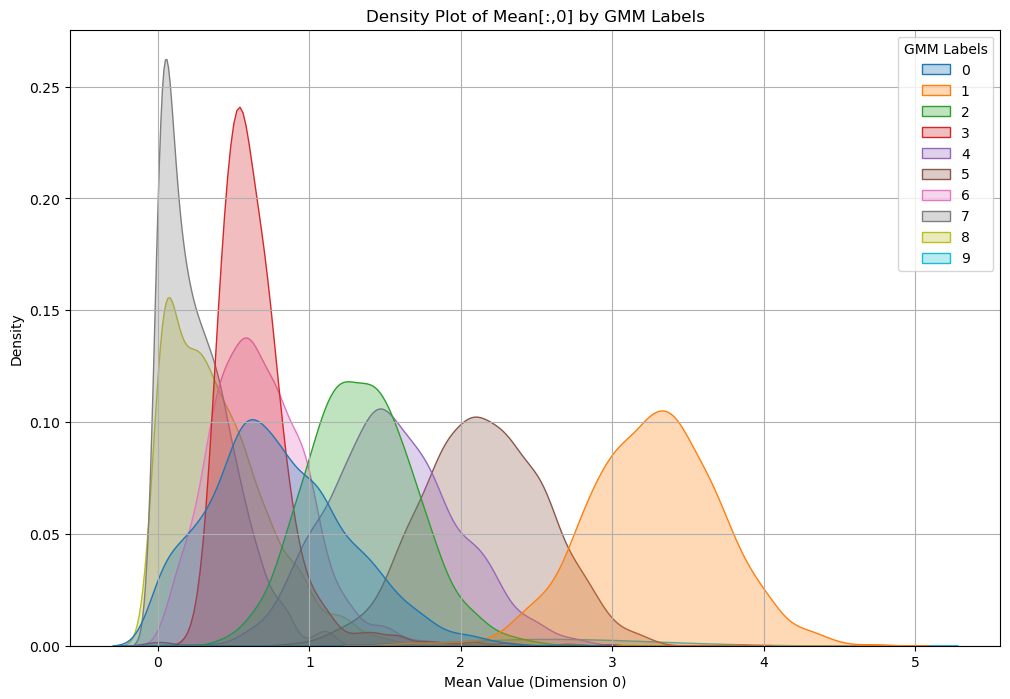

In [ ]:
# Draw latent dim
# 按照components对潜空间的mean、高斯分布、以及真实数据的mean进行绘制。
import pandas as pd

## VAE的mean
mean_np = mean.detach().cpu().numpy()
plot_data = pd.DataFrame({
    'GMM Labels': gmm_labels,
    'Mean Value (Dimension 0)': mean_np[:, 0]
})

plt.figure(figsize=(12, 8))
sns.kdeplot(data=plot_data, x='Mean Value (Dimension 0)', hue='GMM Labels', palette='tab10', fill=True, alpha=0.3)

plt.title('Density Plot of Mean[:,0] by GMM Labels')
plt.xlabel('Mean Value (Dimension 0)')
plt.ylabel('Density')
plt.grid(True)
plt.show()

## VAE的Var
exp_log_var_np = np.exp(log_var.detach().cpu().numpy())
plot_data_exp_log_var = pd.DataFrame({
    'GMM Labels': gmm_labels,
    'Exp(Log_Var) Value (Dimension 0)': exp_log_var_np[:, 0]
})

plt.figure(figsize=(12, 8))
sns.kdeplot(data=plot_data_exp_log_var, x='Exp(Log_Var) Value (Dimension 0)', hue='GMM Labels', palette='tab10', fill=True, alpha=0.3)

plt.title('Density Plot of Exp(Log_Var)[:,0] by GMM Labels')
plt.xlabel('Exp(Log_Var) Value (Dimension 0)')
plt.ylabel('Density')
plt.grid(True)
plt.show()

## VAE的Z
z_np = z.detach().cpu().numpy()
plot_data_z = pd.DataFrame({
    'GMM Labels': gmm_labels,
    'Z Value (Dimension 0)': z_np[:, 0]
})

plt.figure(figsize=(12, 8))
sns.kdeplot(data=plot_data_z, x='Z Value (Dimension 0)', hue='GMM Labels', palette='tab10', fill=True, alpha=0.3)

plt.title('Density Plot of Z[:,0] by GMM Labels')
plt.xlabel('Z Value (Dimension 0)')
plt.ylabel('Density')
plt.grid(True)
plt.show()

## Gaussian总结的数据


(1000,)


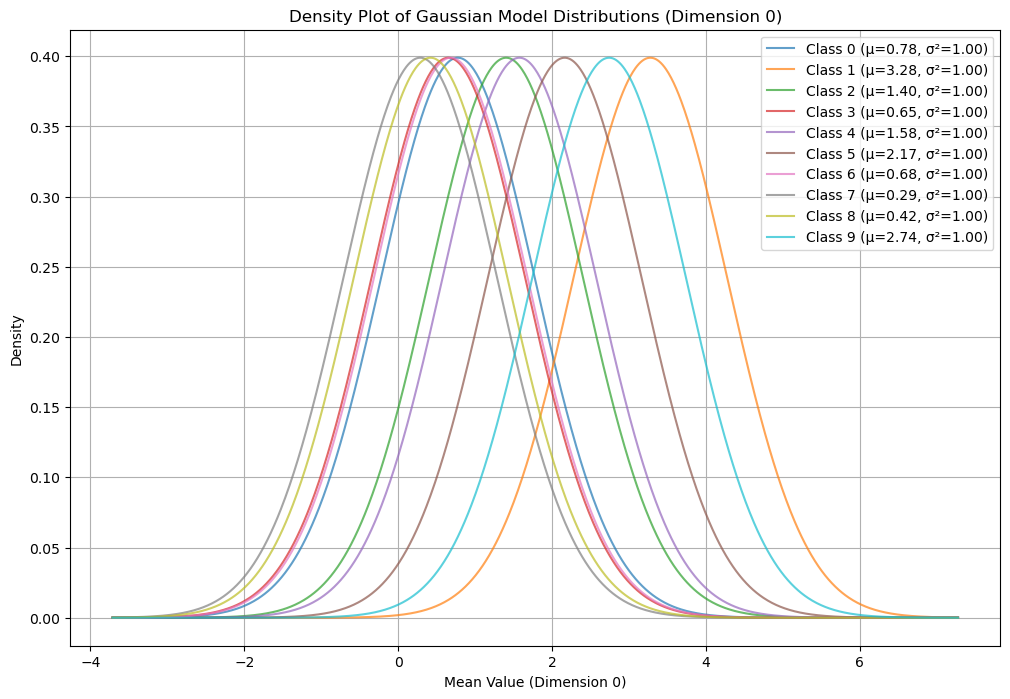

In [53]:
k = 4  # 覆盖大部分概率质量
stds = np.exp(gaussian_vars[:,0])
x_min = np.min(gaussian_means[:,0] - k * stds)
x_max = np.max(gaussian_means[:,0] + k * stds)

x = np.linspace(x_min, x_max, 1000)
print(x.shape)
plt.figure(figsize=(12, 8))

for i, (mu, var) in enumerate(zip(gaussian_means[:,0], stds)):
    y = norm.pdf(x, loc=mu, scale=var)
    plt.plot(x, y, label=f'Class {i} (μ={mu:.2f}, σ²={var:.2f})', color=plt.cm.tab10(i % 10), alpha=0.7)


plt.title('Density Plot of Gaussian Model Distributions (Dimension 0)')
plt.xlabel('Mean Value (Dimension 0)')
plt.ylabel('Density')
plt.grid(True)
plt.legend()
plt.show()

In [60]:
# NC_9每个components的浓度
gaussian_vars.min()

0.0

In [ ]:
threshold = 0.95

print(gaussian_means.shape)
z_sample=np.random.multivariate_normal(gaussian_means[1,:],np.diag(np.exp(gaussian_vars[1,:])),(1,))

(10, 20)


In [18]:
z_prob = F.softmax(model.gaussian.gaussian_log_prob(torch.tensor(z_sample).to(device)), dim=1)

if z_prob.max() > threshold:
    new_X = np.matmul(z_sample, S.cpu().detach().numpy())

In [19]:
z_prob

tensor([[2.0639e-04, 8.9793e-01, 3.6396e-07, 3.3128e-09, 9.4682e-05, 1.0145e-01,
         2.9372e-05, 2.8038e-04, 5.6622e-08, 8.4296e-06]], device='cuda:1',
       dtype=torch.float64, grad_fn=<SoftmaxBackward0>)